For more information see kepstr.blogspot.com

As a precaution

In [2]:
import numpy as np

np.random.seed(42)

This block calculates the signal approximated to the entire graph.
NB! 

In [3]:
import numpy as np
import scipy as sp
from pygsp import *
import matplotlib.pyplot as plt
import time 

#we can optimize this, because laplacian  -> eigv, and after multiply diagonal matrices

max_set = 20
def get_smallest_eigenvalue(new_graph):
    new_graph.compute_fourier_basis()
    
    return (new_graph.e[new_graph.N])


def compute_not_S(N, S):
    not_S = []
    for i in range(0, N):
        if (i not in S):
            not_S.append(i)
            
    return not_S

def compute_L(L, k):
    new_L = L
    for i in range(1, k):
        new_L = L @ new_L

    return new_L 
   
def estimate_cut_off(graph, m, k):
    S = []
    w = []
    graph.compute_laplacian("normalized")
    graph.L = (1/2)*(graph.L + graph.L.T)
    L = compute_L(graph.L, k)
    while(len(S) < m):
        proj = (np.delete(np.delete(L.todense(), S, 0), S, 1))
        eig_val, U = np.linalg.eig(proj)
        small_index = np.argmin(abs(eig_val))
        min_eigv = min(abs(eig_val))
        w.append(np.power(abs(eig_val[small_index]), 1/k))
        minimizer = U[:, small_index]
        v = np.argmax(abs(minimizer))
        not_S = compute_not_S(graph.N, S)
        if (v in not_S):
            print("Requesting a signal from the vertex under the number:", not_S[v])
            S.append(not_S[v])

    return S, w, U[:, 0]


def compute_k(eig_val, cut_off):
    k = 0
    for i in range(0, len(eig_val)):
        if (cut_off > eig_val[k]):
            k += 1
        else:
            break
    
    return k


def give_all_signal(graph, S, signal_S, cut_off):
    
    print("Cut-off frequency is", cut_off)
    k = compute_k(graph.e, cut_off)
    print(k, "Cut-off frequency between  : ", k + 1, "eigenvalue")
    U_k = graph.U[:, range(0, k)]
    U_k_not_S = U_k[compute_not_S(graph.N, S), :]
    U_K_S = U_k[S, :]
    new_f1 = U_k_not_S @ np.linalg.inv(U_K_S.T @ U_K_S) @ U_K_S.T @ signal_S
    new_f = U_k_not_S @ np.linalg.pinv(U_K_S) @ signal_S
    
    return new_f1

def main(graph, signal, S = [], w = 0, minimizer = []):
    graph.compute_laplacian("normalized")
    graph.compute_fourier_basis()
    if (len(S) == 0):
        S = []
        S, w, minimizer = estimate_cut_off(graph, m = max_set, k = 10)
    print("Sampling set:", S)
    cut_off = w[max_set - 1]
    print("Signal on sampling set:", signal[S])
    graph.set_coordinates()
    unknown_signal= give_all_signal(graph, S, signal[S], cut_off)
    all_signal = np.zeros(len(signal))
    all_signal_1 = np.zeros(len(signal))
    all_signal_2 = np.zeros(len(signal))
    all_signal_1[S] = signal[S]
    
    all_signal_2[compute_not_S(len(signal), S)] = unknown_signal[range(len(signal) - len(S))]
    all_signal = all_signal_1 + all_signal_2
    context = []
    context.append(S)
    context.append(w)
    context.append(minimizer)
    
    return all_signal, context

Loading the dataset and building a graph.

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  3. ...  9.  0.  0.]
 [ 0.  0.  0. ...  6.  0.  0.]
 [ 0.  0.  9. ... 10.  0.  0.]]


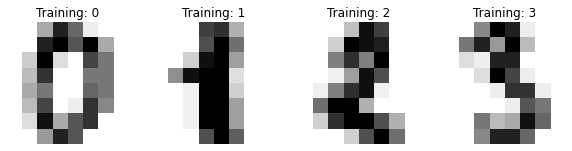

In [4]:
import matplotlib.pyplot as plt

from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

size = 1000

digits =  datasets.load_digits()
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
data = digits.images[range(0, size)]
lst = []
for i in range(0, size):
    lst.append(data[i].reshape(64,))
my_data = np.array(lst)
sigma = 1000 
print(my_data)

G = graphs.NNGraph(my_data, NNtype='knn', k=10, sigma = sigma**2, rescale=False, symmetrize_type='maximum')

Let's look at the resulting graph.

/home/pedashenko/.local/lib/python3.8/site-packages/pygsp/plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)


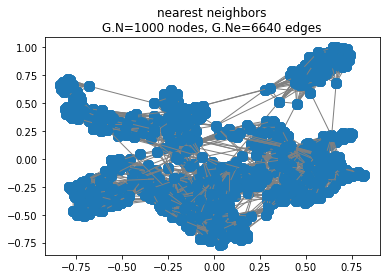

In [5]:
G.set_coordinates()
G.plot()
G.compute_laplacian("normalized")

And let's look at the distribution of eigenvalues.

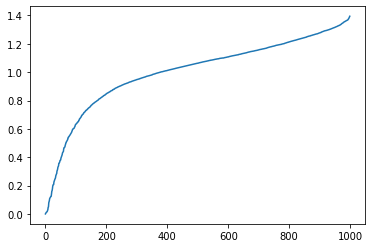

In [6]:
G.compute_fourier_basis()
plt.plot(G.e)
plt.show()

Here calculating predicted membership functions for each class

In [7]:
def make_signal(target, digit):
    new_target = target
    for i in range(0, len(target)):
        if (target[i] == digit):
            new_target[i] = 1
        else:
            new_target[i] = 0
    
    return new_target

target_lst = []
signal_lst = []
ctxt = [[], 0, []]
eps = 0.001
for digit in range(0, 10):
    target = digits.target[range(0, size)]
    target_0 = make_signal(target, digit)
    
    print("Digit:", digit)
    my_signal, ctxt = main(G, target_0, ctxt[0], ctxt[1], ctxt[2])

    target_lst.append(target_0)
    signal_lst.append(my_signal)
    
    if (max(abs(my_signal)) > 0):
        my_signal = my_signal/max(abs(my_signal))

Digit: 0
Requesting a signal from the vertex under the number: 360
Requesting a signal from the vertex under the number: 537
Requesting a signal from the vertex under the number: 410
Requesting a signal from the vertex under the number: 885
Requesting a signal from the vertex under the number: 983
Requesting a signal from the vertex under the number: 259
Requesting a signal from the vertex under the number: 132
Requesting a signal from the vertex under the number: 326
Requesting a signal from the vertex under the number: 682
Requesting a signal from the vertex under the number: 186
Requesting a signal from the vertex under the number: 635
Requesting a signal from the vertex under the number: 938
Requesting a signal from the vertex under the number: 438
Requesting a signal from the vertex under the number: 544
Requesting a signal from the vertex under the number: 613
Requesting a signal from the vertex under the number: 195
Requesting a signal from the vertex under the number: 213
Reque

Function for calculating the final signal

In [8]:
def compute_final_signal(signal_lst):
    final_signal = []
    max_i = 0
    argmax_j = 0
    len_fin_sig = len(signal_lst[0])
    for i in range(len_fin_sig):
        max_i = abs(signal_lst[0][i])
        for j in range(len(signal_lst)): 
            if (max_i < signal_lst[j][i]):    ## maybe we need take abs
                argmax_j = j
                max_i = max(max_i, signal_lst[j][i])
            
        final_signal.append(argmax_j)
        
    return (final_signal)


Building the estimated signal and the true signal

/home/pedashenko/.local/lib/python3.8/site-packages/pygsp/plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)
/home/pedashenko/.local/lib/python3.8/site-packages/pygsp/plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)


Estimated signal 
 [0 1 8 3 4 9 6 7 8 9 9 1 2 3 4 5 6 7 1 9 9 1 2 3 4 5 6 7 8 9 9 9 5 5 6 5 5
 9 1 9 8 4 1 7 7 3 5 1 1 1 8 8 7 1 8 8 1 1 6 3 3 7 3 3 4 6 6 6 4 7 1 5 5 9
 5 1 8 1 1 1 1 7 6 3 2 1 7 4 6 3 1 3 9 1 7 6 1 4 3 1 4 4 5 3 6 9 6 1 7 5 4
 4 7 2 8 8 2 5 7 9 5 4 1 1 4 9 9 1 9 1 1 1 2 3 4 5 6 7 8 9 9 1 2 3 4 5 6 7
 8 9 9 1 2 3 4 5 6 7 1 9 9 9 5 5 6 5 5 9 8 9 1 4 1 7 7 3 5 1 1 1 2 2 7 8 2
 2 1 2 6 3 3 7 3 3 4 6 6 6 4 9 1 5 5 9 5 2 1 2 2 2 1 7 6 3 2 1 7 3 1 3 9 1
 7 6 8 4 3 1 4 4 5 3 6 9 6 1 7 5 4 4 7 2 1 2 2 5 5 4 8 8 4 9 9 8 9 8 8 1 2
 3 4 5 6 7 8 7 7 1 2 3 4 5 6 7 8 7 7 1 2 3 4 5 6 7 8 9 9 9 5 5 6 5 5 9 8 9
 8 4 1 7 7 3 5 1 1 1 2 2 7 8 2 2 1 2 6 3 3 7 3 3 4 6 6 6 4 7 1 5 5 7 5 2 8
 2 2 2 1 7 6 3 2 1 7 4 6 3 1 3 7 1 7 6 8 4 3 1 4 4 5 3 6 7 6 1 7 5 4 4 7 2
 8 2 2 5 7 9 5 4 3 8 4 9 9 8 7 3 3 1 2 3 4 5 6 7 8 9 9 1 2 3 4 5 6 7 8 9 9
 1 2 3 4 5 6 7 8 9 9 9 5 5 6 5 5 9 8 9 8 4 1 7 7 3 5 1 1 1 2 2 7 8 2 2 1 2
 6 3 3 7 3 3 4 6 6 6 4 9 1 5 5 9 5 2 8 2 2 2 1 7 6 3 2 1 7 4 6 3 1 3 9 1 7
 6 8 4

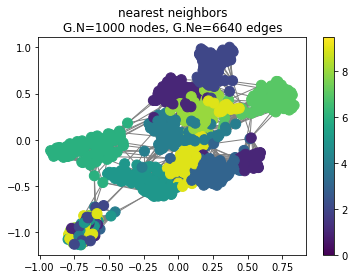

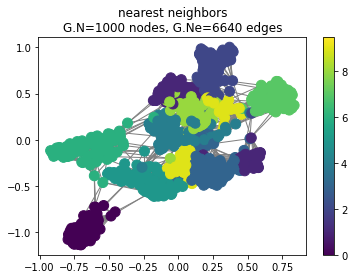

In [9]:
final_signal = compute_final_signal(signal_lst)

G.plot_signal(np.array(final_signal))
G.plot_signal(digits.target[range(0, size)])

print("Estimated signal \n", np.array(final_signal))
print("True signal \n", digits.target[range(0, size)])


Build confusion matrix

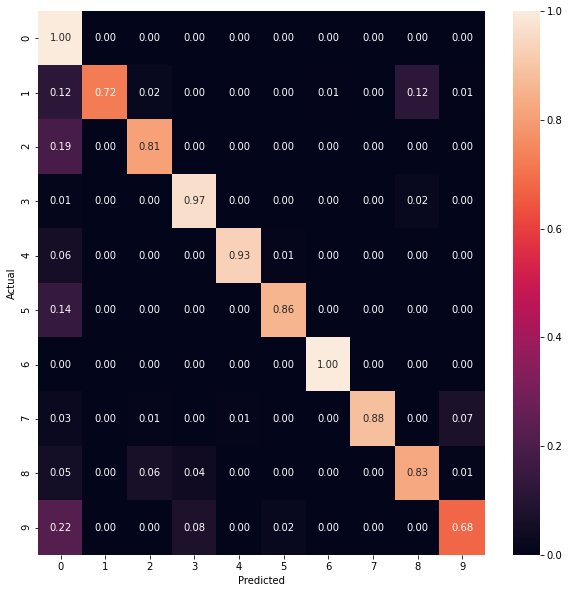

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

cm = confusion_matrix(np.array(final_signal), digits.target[range(0, size)])
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
target_names= "0123456789"
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

Calculate accuracy

In [11]:
from sklearn.metrics import accuracy_score

print("Accuracy is:", accuracy_score(np.array(final_signal), digits.target[range(0, size)] ))

Accuracy is: 0.843


## Simple baseline with KNeighbors

As a training sample, the 20 elements selected by the algorithm above were selected. These 20 items are not removed from the test sample. But even with this in mind, baseline showed an accuracy of ~0.2.

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from numpy.random import default_rng
import numpy as np

X = my_data
y = digits.target[range(0, size)]

np.random.seed(42)
Sampling_set = ctxt[0]
rng = default_rng()
Sampling_set = rng.choice(999, size=20, replace=False)
X_train = my_data[Sampling_set]
y_train = digits.target[range(0, size)][Sampling_set]

neigh = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree')
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X)


print("Accuracy is:", accuracy_score(y, y_pred))
print(y_train)

Accuracy is: 0.74
[3 4 4 3 8 4 1 7 7 5 8 2 8 0 4 6 6 7 9 0]


<h3> Confusion matrix </h3>

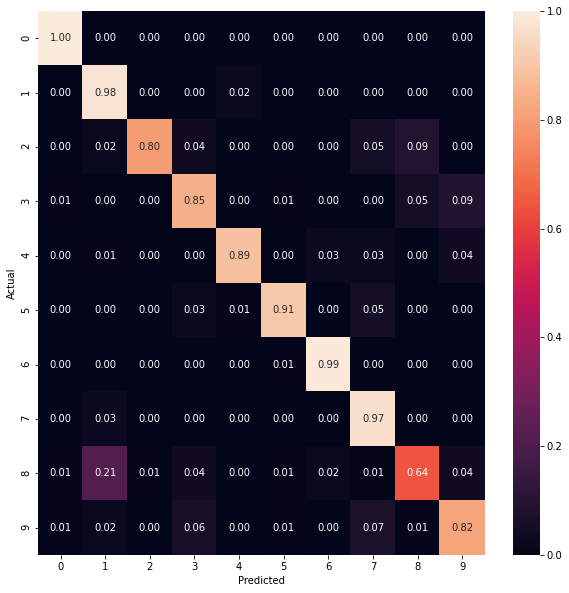

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

cm = confusion_matrix(y, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
target_names= "0123456789"
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

<h3> 3 graph signals: </h3>
1. KNeighbors predicted
2. True
3. The set of vertices that were used in the training sample(yellow)

/home/pedashenko/.local/lib/python3.8/site-packages/pygsp/plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)
/home/pedashenko/.local/lib/python3.8/site-packages/pygsp/plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)
/home/pedashenko/.local/lib/python3.8/site-packages/pygsp/plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)


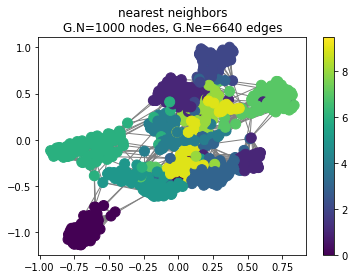

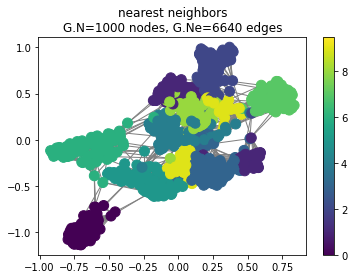

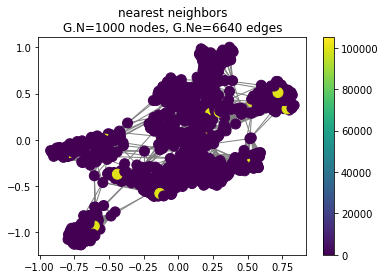

In [14]:
y_set = y_pred.copy()
for i in ctxt[0]:
    y_set[i] = 100000

G.plot_signal(y_pred)
G.plot_signal(digits.target[range(0, size)])
G.plot_signal(y_set)